# CS541: Applied Machine Learning, Spring 2025, Lab 4

Labe 4 is an exercise that explores PCA for data representation. When it comes to high dimensional data with a large amount of examples, PCA is a method that can be used to reduce the dimensions of the data but still keep the important information about the data.

We will be working with PCA and utilizing on 3 datasets, namely:
  * MNIST dataset
  * Wine dataset
  * CIFAR dataset

We will be utilizing the SVM from the last few labs to classify our PCA reduced data.

**Lab Grading**

Labs are hands-on exercises designed to provide guided experience in key concepts through this class.  You are graded based on in-lab participation (not correctness), and **are required to submit** your lab work after class, before Friday of that week.  *Make sure you fill out the attendence form before leaving class*.

For students who miss a lab, you can submit a make-up lab on gradescope by the Friday directly following the lab for partial credit.  Please see the syllabus for the lab grading policy.

## Image Compression using PCA

PCA learns patterns in data to learn how to compress images effectively.



## Can you compress an image using PCA?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_sample_image
import cv2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsOneClassifier

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


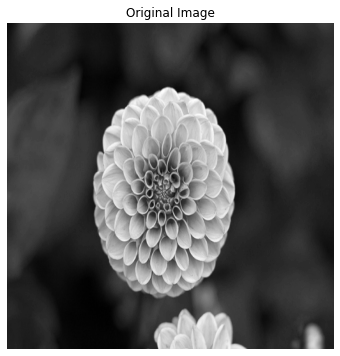

In [2]:
# Load the example image (you can replace this with your own image)
image = load_sample_image("flower.jpg")

image = cv2.resize(image, (512, 512))

# Convert the image to grayscale (if it's not already)
image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Display the original image
plt.figure(figsize=(8, 6))
plt.imshow(image_gray, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

We have only one image, we need to learn patterns in the image that we can use to compress it.

Let's take chunks of the image and treat it as data points.

Specifically, let's take 16*16 chunks.

In [3]:
# Flatten the 2D array into a 1D array
data = image_gray.reshape(16*16, -1)


Now, let's learn the principle components of the image chunks to learn how to compress it - represent it with fewer points.

What does this mean?

In the original image: For each of the 16*16 = 256 chunks, we have 1024 pixels.

Let's compress it such that we can represent it using just 100 pixels.

In [4]:
print("Size of the original data: ", data.shape)

# Define the number of principal components to retain (adjust as needed)
n_components = 100

# Initialize and fit the PCA model
pca = PCA(n_components=n_components)
pca.fit(data)

# Transform the data into the reduced dimensionality
compressed_data = pca.transform(data)

print("Size of the compressed representation: ", compressed_data.shape)

# Inverse transform to get the reconstructed image from the compressed data
reconstructed_image = pca.inverse_transform(compressed_data)

# Reshape the compressed image back to the original shape
reconstructed_image = reconstructed_image.reshape(image_gray.shape)

print("Size of the reconstructed image: ", reconstructed_image.shape)


Size of the original data:  (256, 1024)
Size of the compressed representation:  (256, 100)
Size of the reconstructed image:  (512, 512)


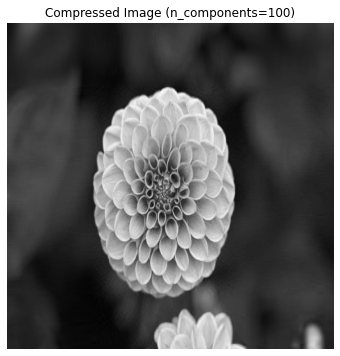

In [5]:
# Display the compressed image
plt.figure(figsize=(8, 6))
plt.imshow(reconstructed_image, cmap='gray')
plt.title(f"Compressed Image (n_components={n_components})")
plt.axis('off')
plt.show()

In [6]:
# Calculate the compression ratio
original_size = image_gray.size
compressed_size = compressed_data.size + pca.components_.size + pca.mean_.size
compression_ratio = original_size / compressed_size

print(f"Compression Ratio: {compression_ratio:.2f}")

# Calculate the mean squared error (MSE) to assess image quality
mse = np.mean((image_gray - reconstructed_image) ** 2)
print(f"Mean Squared Error (MSE): {mse:.2f}")

Compression Ratio: 2.03
Mean Squared Error (MSE): 4.76


In [7]:
print(compressed_data.size)
print(pca.components_.size)
print(pca.mean_.size)

25600
102400
1024


In [8]:
print(original_size)
print(compressed_size)

262144
129024


## Challenge: How much can you compress while still recognizing digits accurately?

In [9]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [10]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

In [11]:
mnist = fetch_openml('mnist_784', as_frame=False, cache=False)

(70000, 784)
Training size:  (52500, 784) (52500,)
Testing size:  (17500, 784) (17500,)


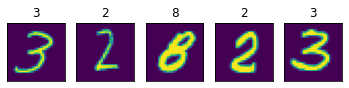

In [12]:
print(mnist.data.shape)

X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print("Training size: ", X_train.shape, y_train.shape)
print("Testing size: ", X_test.shape, y_test.shape)
# remember to compress the test images as well when testing your classifier.
plot_example(X_train, y_train)

In [13]:
y_train[:10]

array([3, 2, 8, 2, 3, 0, 3, 9, 9, 7])

**Note how in the data x_train and x_test, the pixels are flattened into 28*28 = 784**

Can you compress them to represent it with less than 784 pixels?

### Use your knowledge of SVM's and PCA to train a classifer on compressed images of digits!

PCA

In [14]:
n_components = 50  # You can experiment with this number
pca = PCA(n_components=n_components, whiten=True, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


SVM

In [15]:
svm_classifier = SVC(kernel='rbf', C=10, gamma=0.001, random_state=42)
svm_classifier.fit(X_train_pca, y_train)

SVC(C=10, gamma=0.001, random_state=42)

In [16]:
y_pred = svm_classifier.predict(X_test_pca)

# Print classification report and confusion matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1714
           1       0.97      0.99      0.98      1977
           2       0.94      0.94      0.94      1761
           3       0.93      0.93      0.93      1806
           4       0.93      0.96      0.94      1587
           5       0.94      0.94      0.94      1607
           6       0.97      0.98      0.97      1761
           7       0.95      0.96      0.96      1878
           8       0.95      0.91      0.93      1657
           9       0.95      0.91      0.93      1752

    accuracy                           0.95     17500
   macro avg       0.95      0.95      0.95     17500
weighted avg       0.95      0.95      0.95     17500

[[1685    0    5    0    2    6    8    2    6    0]
 [   0 1950    6    9    1    1    0    4    5    1]
 [   8    9 1662   12   16    8   10   14   17    5]
 [   3    6   27 1686    1   36    6   14   21    6]
 [   2    2    8    1 1520   

# Problem 1)
### Here we utilze PCA on the wine dataset

In [65]:
from sklearn.datasets import load_wine
data = load_wine()
print(data.target[[10, 80, 140]])
# Assign the data to X and y and change the X value to float32 and y to int64
# You can search online how to assign the load_wine dataset
X = data.data.astype('float32')
y = data.target.astype('int64')


[0 1 2]


In [66]:
#Split the data so that we have a test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
#Call the StandardScaler function as we have done in previous labs
sc = StandardScaler()

#Use StandardScaler function and fit_transform on the X_train and transform on the X_test
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [68]:

#Call PCA with n_components=1 or 2 and see what result you get what happens if you increase that value?
pca = PCA(n_components=2)

#Use PCA to fit_transform on the X_train and transform on the X_test
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)


In [69]:
#Call an Support Vector classifier, you can try a kernel of poly and C=1
#Or you can try different arrangments and see the results
svm_classifier = SVC(kernel='poly', C=1, random_state=42)

#Fit the svc_classifier to you training data
svm_classifier.fit(X_train, y_train)

SVC(C=1, kernel='poly', random_state=42)

In [70]:
#Use your svc classifier to predict on the test set
y_pred = svm_classifier.predict(X_test)

# Print classification report and confusion matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92        14
           1       0.88      1.00      0.93        14
           2       1.00      1.00      1.00         8

    accuracy                           0.94        36
   macro avg       0.96      0.95      0.95        36
weighted avg       0.95      0.94      0.94        36

[[12  2  0]
 [ 0 14  0]
 [ 0  0  8]]


Q. Call PCA with n_components=1 or 2 and see what result you get. what happens if you increase that value?

**Answer**:

With n_components=1 we get 0.89 accuracy while with n_components=2 we get 0.94 accuracy. Generally, adding more components is expected to further improve accuracy.

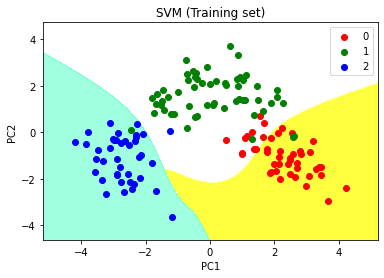

In [71]:
# Predicting the training set
# result through scatter plot
from matplotlib.colors import ListedColormap

X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start=X_set[:, 0].min() - 1,
                               stop=X_set[:, 0].max() + 1, step=0.01),
                     np.arange(start=X_set[:, 1].min() - 1,
                               stop=X_set[:, 1].max() + 1, step=0.01))

plt.contourf(X1, X2, svm_classifier.predict(np.array([X1.ravel(),
                                                  X2.ravel()]).T).reshape(X1.shape), alpha=0.75,
             cmap=ListedColormap(('yellow', 'white', 'aquamarine')))

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                color=ListedColormap(('red', 'green', 'blue'))(i), label=j)

plt.title('SVM (Training set)')
plt.xlabel('PC1')  # for Xlabel
plt.ylabel('PC2')  # for Ylabel
plt.legend()  # to show legend

# show scatter plot
plt.show()

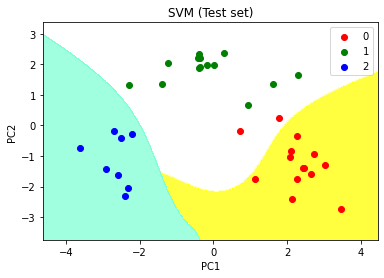

In [72]:
# Visualising the Test set results through scatter plot
X_set, y_set = X_test, y_test

X1, X2 = np.meshgrid(np.arange(start=X_set[:, 0].min() - 1,
                               stop=X_set[:, 0].max() + 1, step=0.01),
                     np.arange(start=X_set[:, 1].min() - 1,
                               stop=X_set[:, 1].max() + 1, step=0.01))

plt.contourf(X1, X2, svm_classifier.predict(np.array([X1.ravel(),
                                                  X2.ravel()]).T).reshape(X1.shape), alpha=0.75,
             cmap=ListedColormap(('yellow', 'white', 'aquamarine')))

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                color=ListedColormap(('red', 'green', 'blue'))(i), label=j)

# title for scatter plot
plt.title('SVM (Test set)')
plt.xlabel('PC1')  # for Xlabel
plt.ylabel('PC2')  # for Ylabel
plt.legend()

# show scatter plot
plt.show()

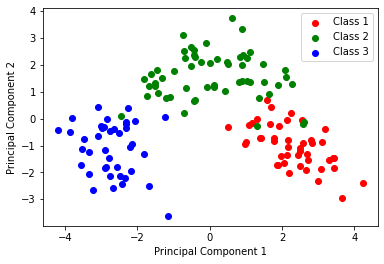

In [74]:
# plot the first two principal components with labels
colors = ["r", "g", "b"]
labels = ["Class 1", "Class 2", "Class 3"]
for i, color, label in zip(np.unique(y), colors, labels):
    plt.scatter(X_train[y_train == i, 0], X_train[y_train == i, 1], color=color, label=label)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

# Problem 2)
### Here we utilze PCA on the CIFAR dataset

In [75]:
from keras.datasets import cifar10
import numpy as np
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
import cv2
from tqdm import tqdm
import numpy as np
from tensorflow import keras
from skimage.feature import hog
from skimage import data, exposure

2025-02-12 12:59:18.119587: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [76]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 9s 0us/step


In [77]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5,32, 32,3), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(labels[y[0]])

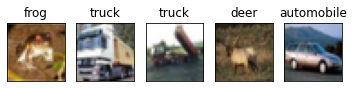

In [78]:
plot_example(x_train,y_train)

In [79]:
def preprocess(xs):
    hog_imgs = []
    for x in tqdm(xs):
        gray = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY) / 255
        fd = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                    	cells_per_block=(2, 2))
        hog_imgs.append(fd)
    return np.array(hog_imgs)

x_train = preprocess(x_train)
x_test = preprocess(x_test)

  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:05<00:00, 1998.87it/s]


In [80]:
print('Traning data shape:', x_train.shape)
print('Testing data shape:', x_test.shape)
print('Training data shape:', y_train.shape)
print('Testing data shape:', y_test.shape)

Traning data shape: (50000, 324)
Testing data shape: (10000, 324)
Training data shape: (50000, 1)
Testing data shape: (10000, 1)


In [81]:
print(y_train[:10])

[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]


In [82]:
#Flatten the y_train and y_test
y_train = y_train.flatten()
y_test = y_test.flatten()


In [83]:
print(y_train[:10])

[6 9 9 4 1 1 2 7 8 3]


In [84]:
#Call PCA and set the number of components to values like 0.8, 4, 8 and see what accuracy you get
#What might be the optimal value
pca_cifar = PCA(n_components=0.8)

#Use PCA to fit_transform your x_train and transform the x_test
X_train_pca = pca_cifar.fit_transform(x_train)
X_test_pca = pca_cifar.transform(x_test)



In [85]:
print(X_train_pca.shape)
print(X_test_pca.shape)

(50000, 66)
(10000, 66)


In [86]:
import time
t1 = time.perf_counter()



#Call the svm classifier and utilize a kernel like 'rbf' and C = 1 and gamma = 0.001
#What different values could you use to improve results? Is it possible to improve it by much?
svm_classifier = SVC(kernel='rbf', C=1, gamma=0.001, random_state=42)

#Fit your svm classifier to the X_train_pca and y_train
svm_classifier.fit(X_train_pca, y_train)

t2 = time.perf_counter()
print('time taken to run:',t2-t1)

time taken to run: 527.3117768779999


In [87]:
t1 = time.perf_counter()

#Predict on your X_train_pca using your svm_classifier
y_pred = svm_classifier.predict(X_train_pca)

# Print classification report and confusion matrix
print(classification_report(y_train, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix(y_train, y_pred), cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
t2 = time.perf_counter()
print('time taken to run:',t2-t1)

              precision    recall  f1-score   support

           0       0.57      0.59      0.58      1000
           1       0.56      0.62      0.59      1000
           2       0.42      0.37      0.39      1000
           3       0.37      0.28      0.32      1000
           4       0.40      0.48      0.44      1000
           5       0.41      0.36      0.39      1000
           6       0.51      0.62      0.56      1000
           7       0.55      0.53      0.54      1000
           8       0.55      0.53      0.54      1000
           9       0.61      0.60      0.60      1000

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.49     10000
weighted avg       0.50      0.50      0.49     10000



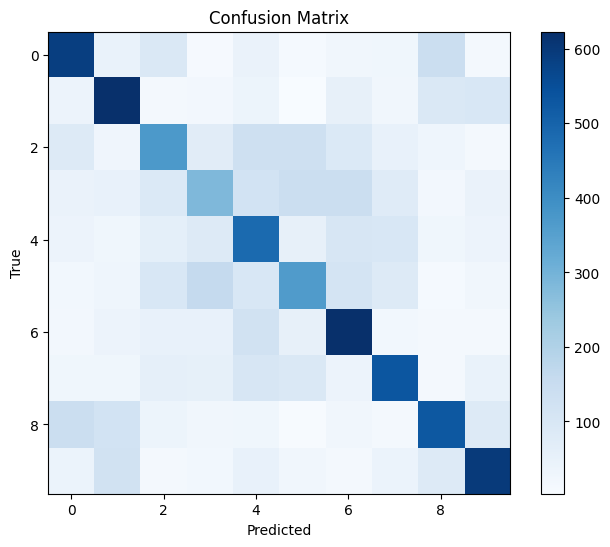

time taken to run: 53.023708467000006


In [ ]:
t1 = time.perf_counter()

#Predict on your X_test_pca using your svm_classifier
y_pred = svm_classifier.predict(X_test_pca)

# Print classification report and confusion matrix
print(classification_report(y_test, y_pred))
# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix(y_test, y_pred), cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
#print(confusion_matrix(y_test, y_pred))
t2 = time.perf_counter()
print('time taken to run:',t2-t1)

Q. Call PCA and set the number of components to values like 0.8, 4, 8 and see what accuracy you get. What might be the optimal value?

**Answer:**

As before, retaining more components generally improves accuracy. However, testing multiple values and computing the reconstruction error is computationally expensive, so we limited our choices to the given values.

### One thing to note is that when trying to train and test on this dataset without PCA, it takes much longer hence PCA can help with speeding up the training process.

### In our case the results are not that great, however SVM's are not the greatest method for this dataset and later in the semester we will be exploring other methods to train and test on this dataset